In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri May  6 15:14:16 2022

@author: zhuch
"""

# -*- coding: utf-8 -*-
"""
Created on Thu May  5 17:30:53 2022

@author: zhuch
"""

import pickle

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.nn.functional as F
import h5py
#%%

# with open("speckle.dat", 'rb') as f:
#     input_list = pickle.load(f)

# with open("SLM.dat", 'rb') as f:
#     output_list =pickle.load(f)
    
#%%

# with open("data/experiment results/Speckle_20x_200um_Round_Scale-2.5x_Natural_M_2_10238_112x112.dat", 'rb') as f:
#     input_list = pickle.load(f)

# with open("data/experiment results/Natural_10238.dat", 'rb') as f:
#     output_list =pickle.load(f)
    
#%%

# with open("data/experiment results/Speckle_20x_400um_Round_Scale-2x_Natural_Order_M_1_112x112_10238.dat", 'rb') as f:
#     input_list = pickle.load(f)

# with open("data/experiment results/Natural_Order_10238.dat", 'rb') as f:
#     output_list =pickle.load(f)


#%%
pathname = "data/ImageNet/ImageNet_dataset_56463.h5"
    

hf = h5py.File(pathname, 'r')

print(hf.keys())

<KeysViewHDF5 ['Earth_B', 'Earth_G', 'Earth_R', 'ImageNet', 'Jupyter_B', 'Jupyter_G', 'Jupyter_R', 'cat', 'horse', 'parrot', 'punch']>


Earth_B, length:1388
Earth_G, length:1388
Earth_R, length:1388
ImageNet, length:50000
Jupyter_B, length:747
Jupyter_G, length:747
Jupyter_R, length:747
cat, length:12
horse, length:12
parrot, length:22
punch, length:12


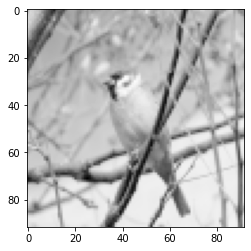

In [3]:
for name in hf.keys():
    print("{}, length:{}".format(name, len(hf[name])))

plt.figure()
plt.imshow(hf['ImageNet'][21999], cmap = 'gray')
plt.show()

In [4]:
with open("data/ImageNet/Speckle_ImageNet_from_0_to_24999_256x256.dat", 'rb') as f:
    input_list = pickle.load(f)

In [ ]:
# IN = h5py.File('Speckle_dataset_2500.h5', 'w')

# IN.create_dataset('speckles2500', data = input_list,  compression="gzip", compression_opts=9)

In [5]:
input_list = input_list[0:500]

In [6]:
output_list = hf['ImageNet']

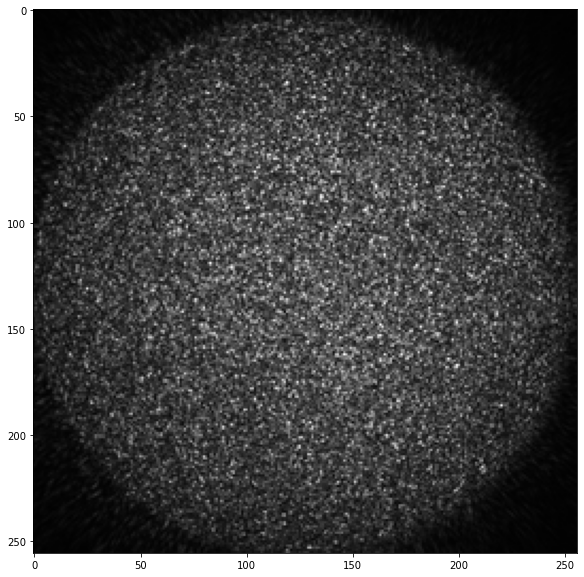

In [7]:
plt.figure(figsize = (10,10))
plt.imshow(input_list[5], cmap = 'gray')
plt.show()

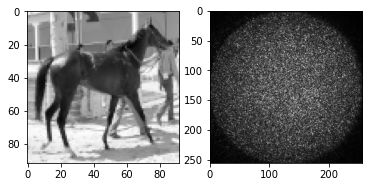

In [9]:
#%%
import matplotlib.pyplot as plt

idx = np.random.randint(0,500)
# idx = 2600

plt.figure()
plt.subplot(121)
plt.imshow(output_list[idx], cmap = 'gray')
plt.subplot(122)
plt.imshow(input_list[idx], cmap = 'gray')
plt.show()

In [10]:
np.shape(input_list)

(500, 256, 256, 1)

In [11]:

#%%
# s = input_list[5]
# x = np.arange(0,112,1)
# y = np.arange(0,112,1)
# X,Y = np.meshgrid(x,y)
# plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(X,Y,s.reshape(112,112), cmap='viridis')
# # plt.colorbar()
# plt.show()

#%%
N_sample = 500
start_id = 0
train_rate = 0.9
train_set_number = int(train_rate*N_sample)

input_dim = (256,256)
output_dim = (92,92)

input_H = np.array(input_list).reshape(-1,1, *input_dim)
label = np.array(output_list).reshape(-1,1, *output_dim)

train_number = np.arange(start_id,start_id + N_sample, dtype ='int')
np.random.shuffle(train_number)

x_train = input_H[train_number[0:train_set_number]]
x_test = input_H[train_number[train_set_number:N_sample]]

y_train =label[train_number[0:train_set_number]]
y_test = label[train_number[train_set_number:N_sample]]

x_train = torch.FloatTensor(x_train/255.0)
x_test = torch.FloatTensor(x_test/255.0)

# x_train = torch.sqrt(x_train)
# x_test = torch.sqrt(x_test)

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
    
    

#%%
del input_list
del output_list
del input_H
del label
#%%
torch.cuda.empty_cache()


In [12]:
batch_size = 2

# create data loaders
train_dataloader = DataLoader(list(zip(x_train, y_train)), batch_size = batch_size )
test_dataloader = DataLoader(list(zip(x_test,y_test)),  batch_size = batch_size )


In [13]:
import math

class complexLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights1 = torch.Tensor(size_out, size_in)
        self.weights1 = nn.Parameter(weights1)  # nn.Parameter is a Tensor that's a module parameter.
#         weights2 = torch.Tensor(size_out, size_in)
#         self.weights2 = nn.Parameter(weights2)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights1, a=math.sqrt(5)) # weight init
#         nn.init.kaiming_uniform_(self.weights2, a=math.sqrt(5)) # weight init


    def forward(self, x):
        x1 = torch.mm(x,self.weights1.t())
#         x1 = torch.square(torch.mm(torch.cos(x),self.weights1.t()))
#         x2 = torch.square(torch.mm(torch.sin(x),self.weights2.t()))
#         x =  torch.add(x1,x2)
        return x1

#%%

device = "cuda"
import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.my1 = complexLayer(256*256, 92*92)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.my1(x)
        x = x.view(-1, 1, 92, 92)
        return x

model = NeuralNetwork().to(device)    


I = np.square(abs( T* Input_image))

I = T' * Input_image

Input_image: 64x64
I: 112x112 
T: 4096x (112x112)



In [40]:
# # Define model
# Nnodes = 2048
# device = 'cuda'
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(256*256, 92*92)
#         self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         x3 = self.flatten(x)
#         x4 = self.fc1(x3)
#         x5 = x4.view(-1,1,92,92)
#         return x5

# model = NeuralNetwork().to(device)
# from torchsummary import summary
# summary(model, (1,256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 65536]               0
            Linear-2                 [-1, 8464]     554,705,168
Total params: 554,705,168
Trainable params: 554,705,168
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.56
Params size (MB): 2116.03
Estimated Total Size (MB): 2116.85
----------------------------------------------------------------


In [22]:
# device = 'cuda'
# Nnodes = 4096

# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(256*256, Nnodes)
#         self.fc2 = nn.Linear(Nnodes, 92*92)
#         self.dp = nn.Dropout(0.3)
#         self.BN = nn.BatchNorm1d(Nnodes)
#         self.BN2 = nn.BatchNorm1d(92*92)  
#         self.flatten = nn.Flatten()
        
#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.BN(self.dp(F.relu(self.fc1(x))))
#         x = self.BN2(self.dp(F.sigmoid(self.fc2(x))))
#         # x = self.dp(F.relu(self.fc2(x)))
#         x = x.view(-1,1,92,92)
#         return x

# model = NeuralNetwork().to(device)
# from torchsummary import summary
# summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 65536]               0
            Linear-2                 [-1, 4096]     268,439,552
           Dropout-3                 [-1, 4096]               0
       BatchNorm1d-4                 [-1, 4096]           8,192
            Linear-5                 [-1, 8464]      34,677,008
           Dropout-6                 [-1, 8464]               0
       BatchNorm1d-7                 [-1, 8464]          16,928
Total params: 303,141,680
Trainable params: 303,141,680
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.79
Params size (MB): 1156.39
Estimated Total Size (MB): 1157.43
----------------------------------------------------------------


In [ ]:
# !pip install torchsummary

In [14]:

#%%
import ssim
loss_fn = ssim.SSIM()

from torch.optim.lr_scheduler import ReduceLROnPlateau
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = Nadam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss
#     return loss.cpu().detach().numpy()       
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Loss:  {test_loss:>8f} \n")
    return test_loss
    
    

In [15]:
#%%  Neural network training


epochs = 50

Loss_train = []
Loss_test = []
steps = []


best_loss = 1.0


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    Loss_train.append(train_loss)
    Loss_test.append(test_loss)
    if test_loss<best_loss:
        best_loss = test_loss
    steps.append(t)
    scheduler.step(test_loss)
print("Done!")    
    

Epoch 1
-------------------------------
Train loss: 0.999624  [    0/  450]
Train loss: 0.999996  [   20/  450]
Train loss: 0.999998  [   40/  450]
Train loss: 1.000000  [   60/  450]
Train loss: 1.000000  [   80/  450]
Train loss: 0.999999  [  100/  450]
Train loss: 1.000001  [  120/  450]
Train loss: 0.999998  [  140/  450]
Train loss: 0.999997  [  160/  450]
Train loss: 1.000002  [  180/  450]
Train loss: 0.999998  [  200/  450]
Train loss: 0.999998  [  220/  450]
Train loss: 1.000001  [  240/  450]
Train loss: 1.000000  [  260/  450]
Train loss: 0.999997  [  280/  450]
Train loss: 0.999997  [  300/  450]
Train loss: 0.999999  [  320/  450]
Train loss: 0.999994  [  340/  450]
Train loss: 0.999999  [  360/  450]
Train loss: 0.999999  [  380/  450]
Train loss: 0.999999  [  400/  450]
Train loss: 0.999999  [  420/  450]
Train loss: 0.999997  [  440/  450]
Test Loss:  0.999999 

Epoch 2
-------------------------------
Train loss: 0.999998  [    0/  450]
Train loss: 0.999998  [   20/  45

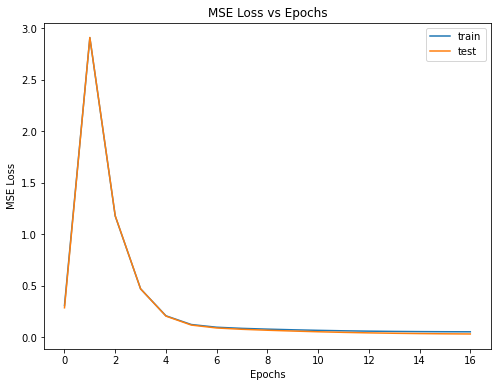

In [14]:

# %%
plt.figure(figsize = (8,6))
plt.title("MSE Loss vs Epochs")
plt.plot(steps, torch.FloatTensor(Loss_train).cpu(), label = 'train')
plt.plot(steps, Loss_test, label = 'test')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()
        
#%%
torch.cuda.empty_cache()
#%%


#%%
# figure configuration
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}


plt.rc('font', **font)


In [15]:
torch.save(model.state_dict(), 'model/exp_mlmodel_highres.dat')

#%%  test model

test_model = NeuralNetwork().to('cpu')
# test_model =UNet().to('cpu')

test_model.load_state_dict(torch.load('model/exp_mlmodel_highres.dat'))


<All keys matched successfully>

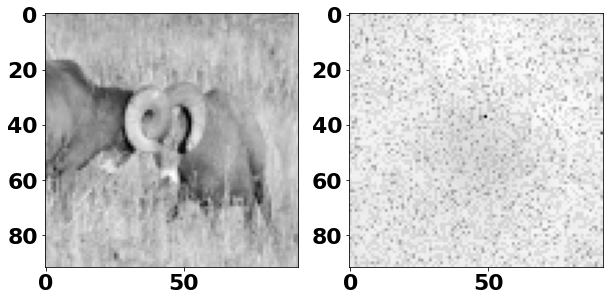

tensor(0.0217)


In [19]:
test_number = np.random.randint(0,50)

with torch.no_grad():
    test_model.eval()
    X= x_test[test_number].reshape(-1,1,*input_dim)
    pred = test_model(X)
plt.figure(figsize = (10,8)) 
plt.subplot(121)
plt.imshow(y_test[test_number].reshape(output_dim), cmap = 'gray')  
plt.subplot(122)
plt.imshow(pred[0].reshape(output_dim), cmap = 'gray')
# plt.imshow(pred[0].reshape(64,64))
plt.show()

print(loss_fn(pred[0], y_test[test_number]))

In [26]:
y_test[test_number]

tensor([[[0.0018, 0.0020, 0.0024,  ..., 0.0019, 0.0020, 0.0020],
         [0.0021, 0.0020, 0.0021,  ..., 0.0016, 0.0017, 0.0018],
         [0.0021, 0.0019, 0.0023,  ..., 0.0010, 0.0015, 0.0015],
         ...,
         [0.0039, 0.0037, 0.0030,  ..., 0.0031, 0.0032, 0.0032],
         [0.0037, 0.0031, 0.0025,  ..., 0.0031, 0.0031, 0.0032],
         [0.0032, 0.0027, 0.0025,  ..., 0.0031, 0.0028, 0.0030]]])

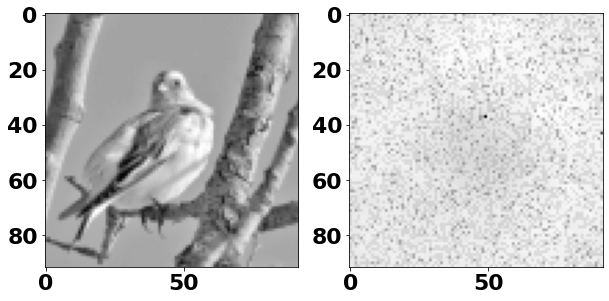

In [21]:
#%%
test_number = np.random.randint(0,90)

with torch.no_grad():
    test_model.eval()
    X= x_train[test_number].reshape(-1,1,*input_dim)
    pred = test_model(X)
plt.figure(figsize = (10,8)) 
plt.subplot(121)
plt.imshow(y_train[test_number].reshape(output_dim), cmap = 'gray')  
plt.subplot(122)
plt.imshow(pred[0].reshape(output_dim), cmap = 'gray')

plt.show()

#%%
# test_number = np.random.randint(0,500)

# with torch.no_grad():
#     test_model.eval()
#     X = x_train[test_number].reshape(-1,1, *input_dim)
#     pred = test_model(X)
  
# plt.figure() 

# plt.subplot(121)
# plt.imshow(y_train[test_number].reshape(64,64), cmap = 'gray')  
# plt.subplot(122)
# plt.imshow(pred[0].reshape(64,64), cmap = 'gray')
# plt.show()